まずはデータの確認・前処理をしていく

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

In [2]:
# train test　はそれぞれ別々だが合体させてnanを補完する形とする

train = pd.read_csv("./input/titanic/train.csv")
test = pd.read_csv("./input/titanic/test.csv")
test["Survived"] = np.nan
titanic = pd.concat([train, test], ignore_index=True, sort=False)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


----------------------------Age------------------------------------

年齢に欠損があるため、穴埋めする（欠損数：１７７）

SVRを使用し、年齢予測する

In [3]:
# Ageに空白のない要素を抽出、学習・評価に使用
# モデルの作成
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

X0 = titanic[titanic["Age"].notnull()][["Pclass", "SibSp", "Parch", "Sex"]]
X = pd.get_dummies(X0, dtype="uint8")
y = titanic[titanic["Age"].notnull()]["Age"]

model = SVR(kernel="rbf", gamma=0.1, C=10)
cv_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)

np.mean(cv_scores)

-152.5951819650214

In [4]:
# 作成したモデルにて、欠損値の補完をする
age_nandata0 = titanic[titanic["Age"].isnull()][["Pclass", "SibSp", "Parch", "Sex"]]
age_nandata = pd.get_dummies(age_nandata0, dtype="uint8")
model.fit(X, y)
pred_age = model.predict(age_nandata)
titanic.loc[(titanic.Age.isnull()), "Age"] = pred_age
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

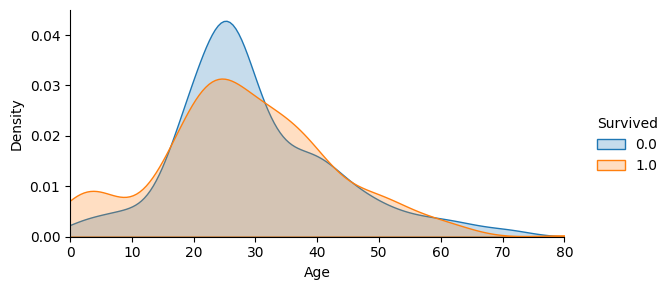

In [5]:
# 年齢別生存曲線と死亡曲線
plt.figure(layout="constrained")
facet = sns.FacetGrid(titanic[0:890], hue="Survived", aspect=2)
facet.map(sns.kdeplot, "Age", fill=True)
facet.set(xlim=(0, titanic.loc[0:890, "Age"].max()))
facet.add_legend()
facet.tight_layout()

２０～３０代の死亡率が高い

In [6]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


そのほかの欠損値補完をしていく

In [7]:
# Fare(運賃)の補完　1308/1309
# Pclass(階級) Embarked(乗船場所)が関連してそう
# 上記2つの要素の最頻値の組み合わせの中央値を欠損値として補完する

P_E_mode = titanic[["Pclass", "Embarked"]].mode().values
P_E_mode_select = titanic[(titanic["Pclass"] == P_E_mode[0, 0]) & (titanic["Embarked"] == P_E_mode[0, 1])]
fill_fare = P_E_mode_select["Fare"].median()
titanic["Fare"] = titanic["Fare"].fillna(fill_fare)

In [8]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [9]:
# cabin(チケット番号)の補完　295/1309
# Unknownで補完し、頭文字を新しい特徴量に置き換える

titanic["Cabin"] = titanic["Cabin"].fillna("Unknown")
titanic["Cabin_label"] = titanic["Cabin"].str[0]
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1307 non-null   object 
 12  Cabin_label  1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


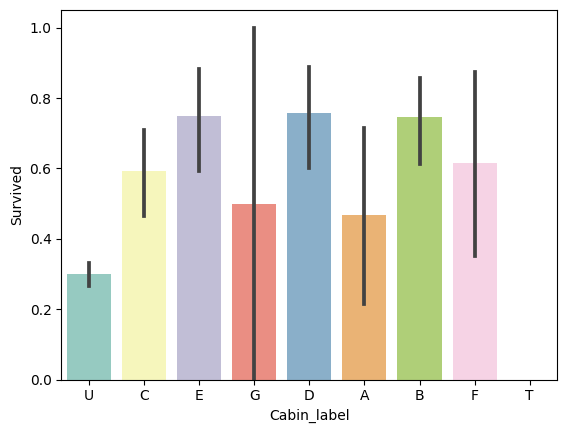

In [10]:
# 棒グラフにすると
# 欠損値の生存率が明らかに低い　＝　これは特徴として現れたのでこれ以上細かくする必要はない
sns.barplot(x="Cabin_label", y="Survived", data=titanic, palette="Set3")
plt.show()

In [11]:
# Embarkedの補完　1307/1309
fill_Embarked = titanic["Embarked"].mode().values
titanic["Embarked"] = titanic["Embarked"].fillna(fill_Embarked[0])
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Cabin_label  1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

titanic_select = titanic[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Cabin_label"]]
titanic_select_1hot = pd.get_dummies(titanic_select, dtype="uint8")
train_data = titanic_select_1hot[titanic_select_1hot["Survived"].notnull()]
test_data = titanic_select_1hot[titanic_select_1hot["Survived"].isnull()].drop("Survived", axis=1)
X = train_data.values[:, 1:]
y = train_data.values[:, 0]
test_x = test_data.values

select = SelectKBest(k="all")
model = RandomForestClassifier(random_state=0, warm_start=True, n_estimators=25, max_depth=6, max_features="sqrt")
pipeline = make_pipeline(select, model)
pipeline.fit(X, y)
cv_result = cross_validate(pipeline, X, y, cv=7)
print("mean_score = ", np.mean(cv_result["test_score"]))
print("mean_std = ", np.std(cv_result["test_score"]))

mean_score =  0.8193194600674917
mean_std =  0.018168609228250743


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [13]:
# ----- Submit dataの作成　-------
# test:ディレクトリ「input」内のtest.csv
PassengerId = test["PassengerId"]
predictions = pipeline.predict(test_x)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("my_submission.csv", index=False)